In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Identity
import math, copy


### 1. Single-user RL agent : 진척율 70%
### 2. Meta learner : 진척율 : 20%
### 3. Language models : 진척율 : 0% 

In [4]:
class DenseBlock(Layer):
    def __init__(self, num_out_features, dilation_rate, **kwargs):
        super().__init__(**kwargs)
        self.filters = num_out_features
        self.dilation_rate = dilation_rate
        self.conv1d_1 = tf.keras.layers.Conv1D(filters=self.filters, kernel_size=2, padding='causal', dilation_rate=self.dilation_rate)
        self.conv1d_2 = tf.keras.layers.Conv1D(filters=self.filters, kernel_size=2, padding='causal', dilation_rate=self.dilation_rate)

    def call(self, input):
        """
        input_shape : (minibatch_size, seq_len, num_features)
        output_shape : (minibatch_size, seq_len, num_features+self.filters) 
        """
        xf, xg = self.conv1d_1(input), self.conv1d_2(input)
        activations = tf.keras.activations.tanh(xf)*tf.keras.activations.tanh(xg)
        output = tf.concat([input, activations], axis=-1)
        return output

In [5]:
class TCBlock(Model):
    def __init__(self, seq_len, num_in_features, num_out_features, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.num_in_features = num_in_features
        self.num_out_features = num_out_features
        self.tcblock = self.get_tcblock()

    def get_tcblock(self):
        input = tf.keras.Input(shape=(self.seq_len, self.num_in_features))
        num_dilation = int(math.ceil(math.log(self.seq_len, 2)))
        x = DenseBlock(num_out_features=self.num_out_features, dilation_rate=2)(input)
        for i in range(2, num_dilation+1):
            x = DenseBlock(num_out_features=self.num_out_features, dilation_rate=int(math.pow(2, i)))(x)
        TCBlock = Model(inputs=input, outputs=x)
        return TCBlock
        
    def call(self, input):
        """
        input_shape : (minibatch_size, seq_len, num_features)
        output_shape : (minibatch_size, seq_len, num_features+ceil(log_2_seq_len)*self.filters) 
        """
        return self.tcblock(input)

In [6]:
class AttentionBlock(Model):
    def __init__(self, seq_len, key_dim, val_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.key_dim = key_dim
        self.val_dim = val_dim
        self.query_layer = Dense(self.key_dim)
        self.key_layer = Dense(self.key_dim)
        self.value_layer = Dense(self.val_dim)
        self.sqrt_k = math.sqrt(self.key_dim)
        self.mask = tf.where(tf.linalg.band_part(tf.ones(shape=(self.seq_len, self.seq_len)), -1, 0) == 0, float('-inf'), 0) 

    def call(self, input):
        """
        input_shape : (minibatch_size, seq_len, num_features)
        output_shape : (minibatch_size, seq_len, num_features+key_dim) 
        """
        queries = self.query_layer(input)
        keys = self.key_layer(input)
        values = self.value_layer(input)
        logits = tf.linalg.matmul(queries, keys, transpose_b=True)/self.sqrt_k
        logits += self.mask 
        probs = tf.nn.softmax(logits)
        read = tf.linalg.matmul(probs, values)
        output = tf.concat([input, read], axis=-1)
        return output



In [10]:
class SANIL(Model):
    def __init__(self, seq_len, num_in_features, architecture, output_layer=None, **kwargs):
        """
        A Tensorflow implementation of the SANIL model from 'A Simple Neural Attentive Meta-Learner' by Nikhil Mishra et al. (https://arxiv.org/abs/1707.03141).
        Permission is hereby granted, free of charge, to any person.
        """        
        super().__init__(**kwargs)        
        self.seq_len = seq_len
        self.num_in_features = num_in_features
        self.architecture = architecture
        self.snail_layers = []
        self.changed_in_features = self.num_in_features
        for layer_info in self.architecture:
            try:
                self.snail_layers.append( TCBlock(seq_len=self.seq_len, num_in_features=self.changed_in_features, num_out_features=layer_info['tc']) )
                self.changed_in_features += int(math.ceil(math.log(self.seq_len, 2)))*layer_info['tc']          
            except:
                self.snail_layers.append( AttentionBlock(seq_len=self.seq_len, key_dim=layer_info['attention'][0], val_dim=layer_info['attention'][1]) )
                self.changed_in_features += layer_info['attention'][1]  
        if output_layer:
            self.output_layer = copy.deepcopy(output_layer)
        else:
            self.output_layer = Identity(trainable=False)

                
    def call(self, input, vervose=False):
        x = input
        if vervose : print(f'input_shape: {x.shape}')
        for layer in self.snail_layers:
            x = layer(x)
            if vervose : print(f'x_shape: {x.shape}')
        output = self.output_layer(x)
        if vervose : print(f'output_shape: {output.shape}')
        return output




minibatch_size = 2
seq_len, num_in_features = 10, 2
architecture = ( {'tc':2}, {'tc':2}, {'attention':[2, 2]}, {'tc':2}, {'attention':[3, 3]} )
snail = SANIL(seq_len, num_in_features, architecture)
input = tf.random.normal(shape=(minibatch_size, seq_len, num_in_features))
snail(input)
snail.summary()


Model: "sanil_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tc_block_3 (TCBlock)        multiple                  176       
                                                                 
 tc_block_4 (TCBlock)        multiple                  432       
                                                                 
 attention_block_2 (Attentio  multiple                 114       
 nBlock)                                                         
                                                                 
 tc_block_5 (TCBlock)        multiple                  752       
                                                                 
 attention_block_3 (Attentio  multiple                 261       
 nBlock)                                                         
                                                                 
 identity_1 (Identity)       multiple                  0   

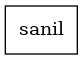

In [8]:
tf.keras.utils.plot_model(snail)